In [17]:
from choquet_integral import *
import numpy as np
import itertools
import math
import inspect
import matplotlib.pyplot as plt
import csv
import sklearn.metrics as metrics
from sklearn import datasets
from sklearn.preprocessing import scale
import pandas
# from pyclustertend import vat, ivat
import matplotlib.pyplot as plt
from emd_clustertend import *
import scipy.io as sio
from scipy.spatial import distance

In [19]:
def vat(dm):
    vat_res = np.zeros_like(dm)
    indices = np.zeros(vat_res.shape, dtype=(int,2))
    K = set(np.arange(0,dm.shape[0],1))
    P = np.zeros(dm.shape[0],dtype=int)
    I = set()
    J = set()

    (i,j) = np.unravel_index(dm.argmax(), dm.shape)
    
    P[0] = i
    I.add(i)
    J = K - I

    for r in range(1,dm.shape[0]):
        temp_matrix = np.zeros((len(I),len(J)))
        matrix_indices = np.zeros(temp_matrix.shape,dtype=(int,2))
        
        for s in range(len(I)):
            for t in range(len(J)):
                temp_matrix[s,t] = dm[list(I)[s],list(J)[t]]
                matrix_indices[s,t] = (list(I)[s], list(J)[t])
                

        (i,j) = np.unravel_index(temp_matrix.argmin(), temp_matrix.shape)
        (i,j) = matrix_indices[i,j]
        
        P[r] = j
        I.add(j)
        J = J - {j}
        
    for i in range(len(dm)):
        for j in range(len(dm)):
            vat_res[i,j] = dm[P[i],P[j]]
            indices[i,j] = (P[i],P[j])
                              
        
    return (vat_res, indices)

def ivat(odm):
    Dp = np.zeros_like(odm)
    for r in range(1,odm.shape[0]):
        j = np.argmin(odm[r,0:r])
        Dp[r][j] = odm[r][j]
        for m in range(0,r):
            if m != j:
                Dp[r][m] = max(odm[r][j],Dp[j][m])         
                
    for i in range(len(odm)):
        for j in range(len(odm)):
            if j >= i:
                Dp[i][j] = Dp[j][i]
    return Dp


def pairwise_dissimilarity(X,euclidean=False):
    pairwise = np.zeros((X.shape[0],X.shape[0]))
    distance_matrix = gen_unit_distance_matrix(X.shape[1])
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            if i == j:
                pairwise[i][j] = 0
            else:
                if euclidean:
                    diff = distance.euclidean(X[i],X[j])
                else:
                    diff = pyemd.emd(X[i],X[j],distance_matrix)
#                 diff = distance.euclidean(X[i],X[j])
                pairwise[i][j]=diff
    return pairwise

In [20]:
# our integral
chi = ChoquetIntegral()

# load the training file 
# 02.txt: https://github.com/aminb99/remote-sensing-nn-datasets/blob/master/AID_4net_dataset/NNFold_1/Fold_1/test/02.txt
# _02.txt: https://github.com/aminb99/remote-sensing-nn-datasets/blob/master/AID_dataset/NNFold_1/Fold_1/test/02.txt
df = pandas.read_csv('02.txt')
df

# how many nets? 
n = 4 # 7

In [21]:
# suck out labels and data
training_labels = np.asarray( df.values )[:,n]
training_data = np.asarray( df.values )[:,0:n]

In [22]:
# for class ?, make this a binary learning problem
locs = np.where(training_labels == 1)
print(locs)
labels = np.zeros(training_labels.shape)
labels[locs] = 1

(array([  0,   8,   9,  69,  76, 105, 138, 190, 200, 221, 227, 248, 342,
       352, 383, 411, 442, 484, 612, 633, 780, 807, 876, 901, 912, 925,
       950, 965, 971], dtype=int64),)


In [23]:
# train the integral
chi.train_chi(training_data.transpose(), labels)
print(chi.fm)

{'[1]': 0.007301042070360983, '[2]': 3.168038462656342e-05, '[3]': 0.0001580437632328804, '[4]': 0.004358436395386026, '[1 2]': 0.12177233024679085, '[1 3]': 0.4984426657599827, '[1 4]': 0.2860080931753677, '[2 3]': 0.0005748642723022515, '[2 4]': 0.99134681393906, '[3 4]': 0.9097324736104253, '[1 2 3]': 0.9940898513618791, '[1 2 4]': 0.9987471770458044, '[1 3 4]': 0.9956525757188976, '[2 3 4]': 0.9999609819692074, '[1 2 3 4]': 1.0}


In [7]:
#distance matrix code from Matt
initial = []
for i in range(n):
    initial.append(i+1)
    
a = itertools.permutations(initial,n)
b = np.ndarray((math.factorial(n),n),dtype=int)
c = np.ndarray((math.factorial(n),n),dtype=float)
for i,val in enumerate(a):
    b[i] = np.asarray(val)
    
    c_build = np.ndarray(n)
    for j in range(len(b[i])):
        if j == 0:
            c_build[j] = chi.fm[str(b[i][0:1])]
        else:
            c_build[j] = (chi.fm[str(np.sort(b[i][0:j+1]))]) - (chi.fm[str(np.sort(b[i][0:j]))])

    c[i] = c_build

0.5917976670624676 0.45797900973341427
0.4241817677512918 0.32516761852486914


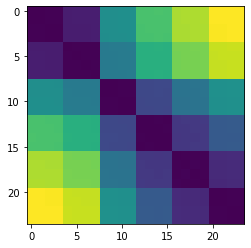

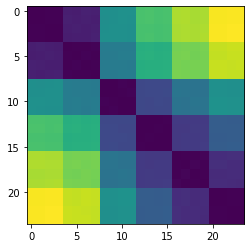

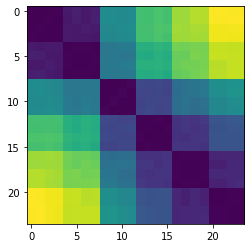

<Figure size 432x288 with 0 Axes>

In [57]:
C = c
# remote_dis = pairwise_dissimilarity(np.asarray(chi.generate_walk_diffs()),euclidean=True)
# mat_dict = {}
# mat_dict['remote_dis'] = remote_dis
# sio.savemat("remote_mat.mat",mat_dict)
# (vat_img,indices) = vat(remote_dis)
# plt.imshow(vat_img,cmap='gray')

diss1 = pairwise_dissimilarity(np.asarray(chi.generate_walk_diffs()),euclidean=True)
diss2 = pairwise_dissimilarity(np.asarray(chi.generate_walk_diffs()),euclidean=False)

(vat_img1,indices1) = vat(diss1)
(vat_img2,indices2) = vat(diss2)



max_val = np.max([diss1,diss2])
plt.figure()
plt.imshow(vat_img1/max_val)
plt.figure()
plt.imshow(np.rot90(np.rot90(vat_img2))/max_val)
plt.figure()
plt.imshow(vat_img1 - np.rot90(np.rot90(vat_img2)))
plt.figure()
print(np.mean(diss1),np.std(diss1))
print(np.mean(diss2),np.std(diss2))
# ivat_img = ivat(vat_img)
# plt.imshow(ivat_img,cmap='gray')


In [ ]:
# I want to plot it

#vat
plt.figure()
color_map = plt.imshow(a)
color_map.set_cmap("gray")
#plt.colorbar()

#ivat - dang, an't as straight forward due to transform (I will have to think about!)
plt.figure()
color_map = plt.imshow(a,vmin=0,vmax=1)
color_map.set_cmap("gray")

In [ ]:
# find the unique sorts
sortorder = np.argsort( (-1) * training_data )
print(sortorder)
unique_rows = np.unique(sortorder, axis=0)
print(unique_rows)
Nunique = unique_rows.shape[0]
print(Nunique)

In [ ]:
#distance matrix on just unique sorts
d = np.ndarray((Nunique,n),dtype=float)
for i in range(Nunique):
    b = np.asarray(unique_rows[i]) + 1
    c_build = np.zeros(n)
    for j in range(n):
        if j == 0:
            c_build[j] = chi.fm[str(b[0:1])]
        else:
            c_build[j] = (chi.fm[str(np.sort(b[0:j+1]))]) - (chi.fm[str(np.sort(b[0:j]))])
    d[i] = c_build

In [ ]:
# what are these operators? plot them out
np.set_printoptions(formatter={'float': '{: 0.9f}'.format})
for i in range(Nunique):
    print(d[i])

In [ ]:
#dissimilarity matrix, i want to see it unsorted
pwd = metrics.pairwise_distances(d,metric='euclidean')
color_map = plt.imshow(pwd)
color_map.set_cmap("gray")
plt.colorbar()

In [ ]:
remote_dis = emd_pairwise_dissimilarity(d)
mat_dict = {}
mat_dict['remote_dis'] = remote_dis
sio.savemat("remote_mat.mat",mat_dict)

In [ ]:
# vat and ivat on just the seen walks
C = d
b = vat(C, return_ODM=True)
a = ivat(C, return_D_prim=True)

In [ ]:
print(d)
# naive extraction
ListOfOps = np.asarray([0])
Thresh = 0.1
for i in range(1,Nunique):
    dist = np.zeros( ListOfOps.shape[0] )
    for j in range(ListOfOps.shape[0]):
        dist[j] = np.sqrt(np.sum(np.power(d[i]-d[ListOfOps[j]],2.0)))
    # new...?
    # look at the thing that its closest to, is it greater than some threshold?
    if( np.amin(dist) > Thresh ):
        ListOfOps = np.append(ListOfOps,i)
# here are our operators ...
print(ListOfOps)
print(d[ListOfOps])